In [1]:
import os
import time
import pickle
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
import torch
import torch.optim as optim

from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold, StratifiedKFold
from category_encoders import TargetEncoder, OneHotEncoder
from math import sqrt
from datetime import datetime

In [22]:
from src.utils import check_stationarity, get_scaler, get_sample_weight, load_word2vec_embeddings, get_torch_optimizer, dummy_lagged_df
from src.arima import grid_search_arima
from src.sarimax import grid_search_sarimax
from src.ml_model import grid_search_ml, get_model, one_step_prediction as one_step_ml_prediction
from src.rnn import load_data, load_data_forecast, train_rnn, eval_rnn, one_step_prediction, grid_search_rnn, TimeSeriesDataset, ForecastModel

# Imputing Visitor Arrivals for Chile and Maldives
## Baseline of simple SARIMA 

In [3]:
imputed_dir = './data/imputed/'

In [4]:
aus_df = pd.read_csv(os.path.join(imputed_dir, 'Chile.csv'))
aus_df['Date'] = pd.to_datetime(aus_df['Date'])
aus_df = aus_df[aus_df['Date'] < '2020-01-01']
aus_df = aus_df.set_index('Date')

In [5]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'FSI', 'FXAgainstChina', 'Temperature', 'Precipitation']
target = 'VisitorArrivals'

train_df = aus_df[[target] + candidates]
train_df = train_df.loc[train_df[target].first_valid_index(): train_df[target].last_valid_index()]
train_x, train_y = train_df[candidates], train_df[target]
# train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)
train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [6]:
len(test_y) / (len(train_y) + len(test_y))

0.125

/scratch/zt00296/Projects/tourism-forecasting/src/utils.py:45: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)



The series isn't stationary


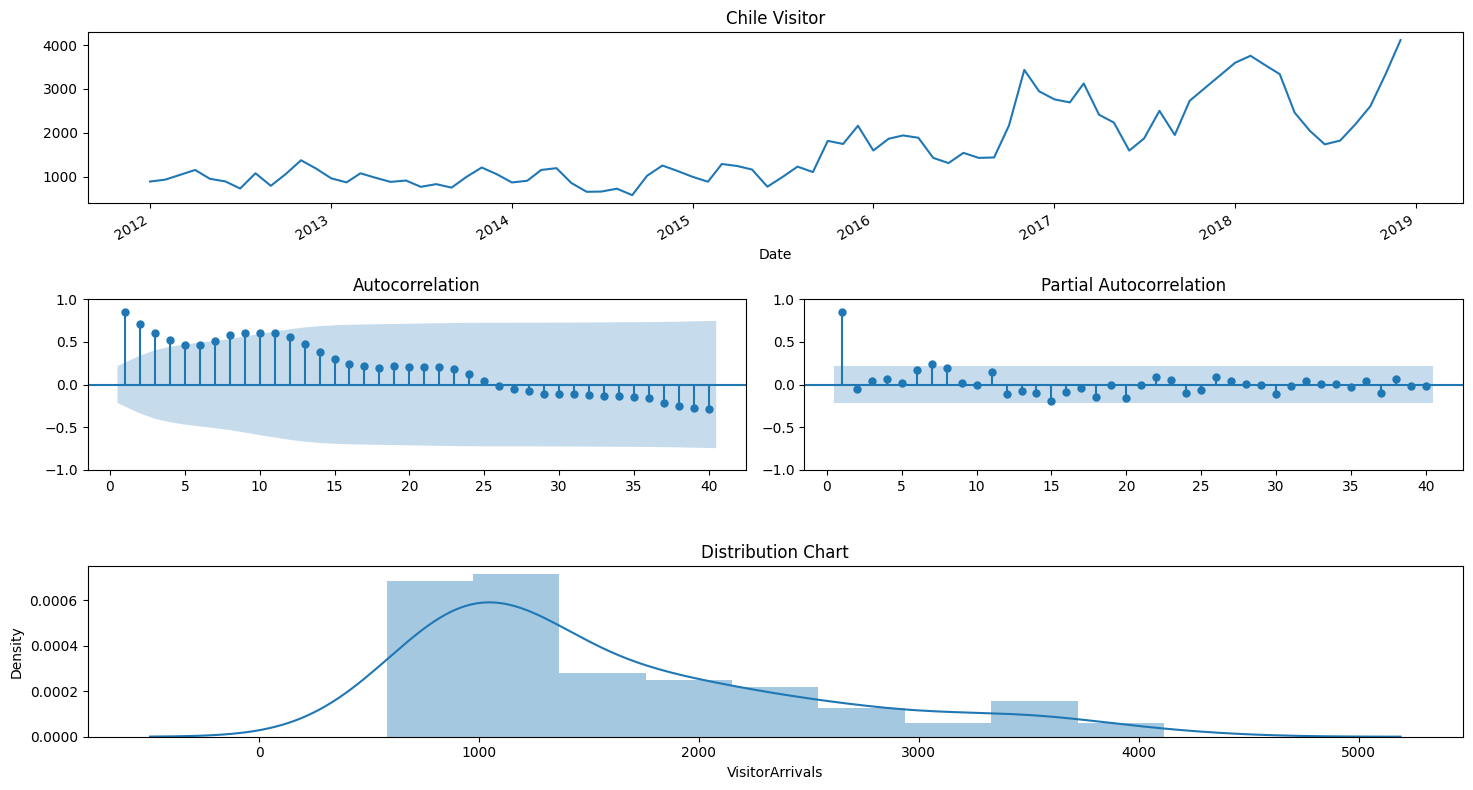

In [7]:
# find parameter analytically
check_stationarity(train_y.dropna(), title='Chile Visitor')

/scratch/zt00296/Projects/tourism-forecasting/src/utils.py:45: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)



The series isn't stationary


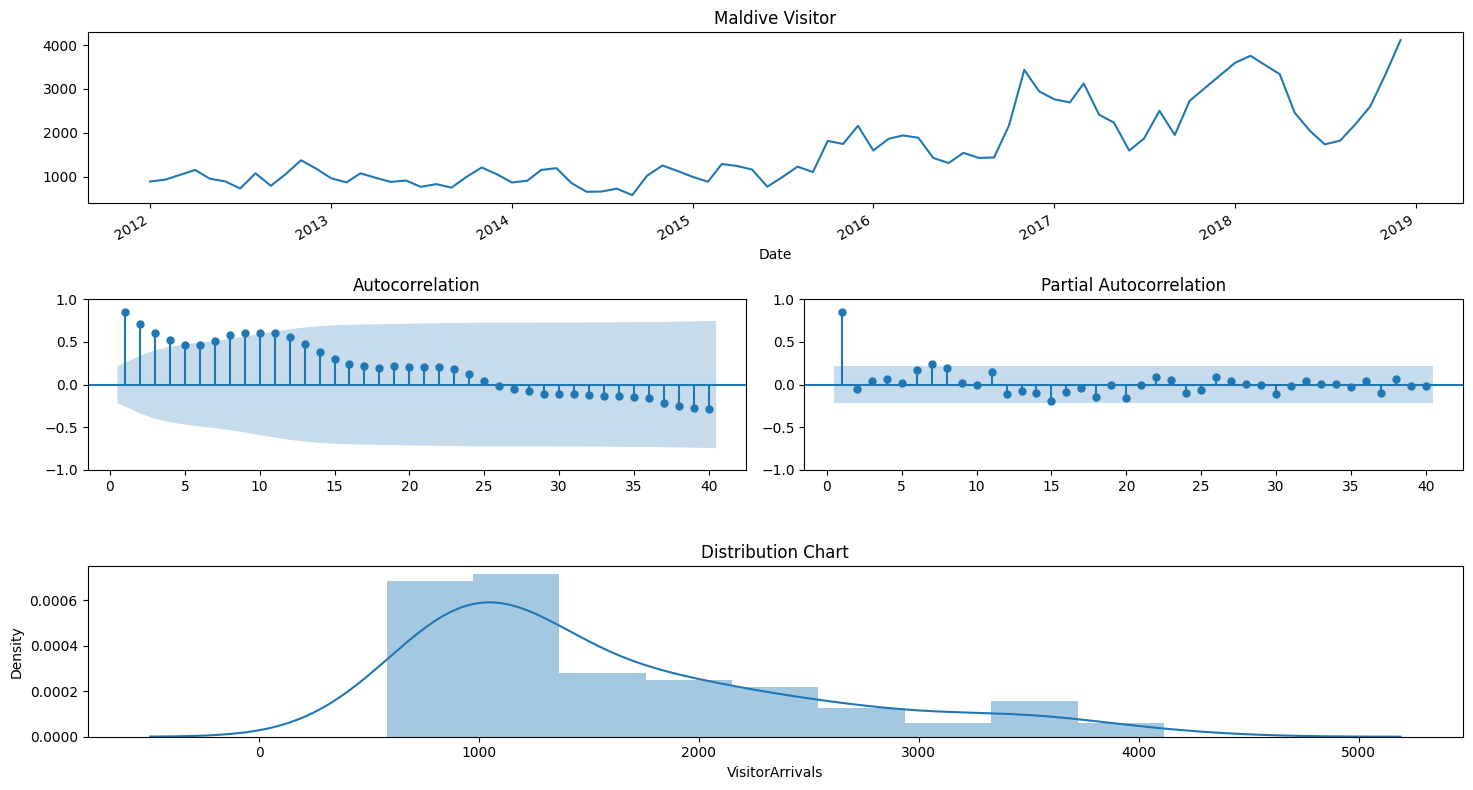

In [8]:
# find parameter analytically
check_stationarity(train_y.dropna(), title='Maldive Visitor')

/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(3, 0, 0), (1, 0, 0, 12), 'c'] 276.49106960737214


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


RMSE: 276.4976655050142
R2 0.7803632838389468


<Axes: xlabel='Date'>

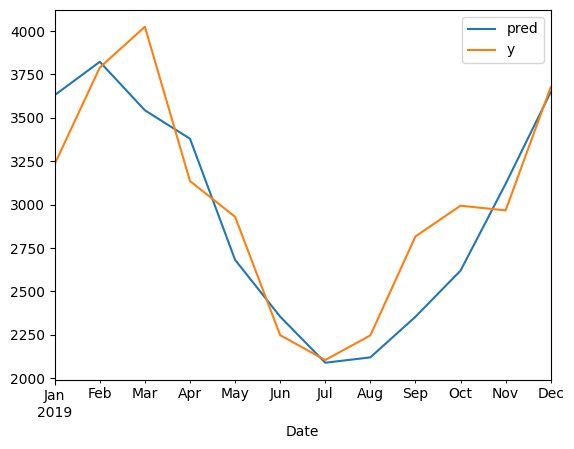

In [9]:
best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y, cv=True)
print(best_param, best_rmse)
sarima_model = sm.tsa.statespace.SARIMAX(train_y, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
result = sarima_model.fit(disp=False)
pred = result.forecast(len(test_y))
print('RMSE:', sqrt(mean_squared_error(test_y, pred)))
print('R2', r2_score(test_y, pred))
pd.concat([pd.Series(pred, name='pred', index=test_y.index), pd.Series(test_y, name='y')], axis=1).plot()

In [10]:
# repeat for chile and maldives
sarima_pred, all_y = [], []
for f in ['Chile.csv', 'Maldives.csv']:
    print('processing', f)
    df = pd.read_csv(os.path.join(imputed_dir, f))
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[df['Date'] < '2020-01-01']
    df = df.set_index('Date')
    train_y = df[target]
    train_y = train_y.loc[train_y.first_valid_index(): train_y.last_valid_index()]
    train_y, test_y = train_y.iloc[:-1*12], train_y.iloc[-1*12:]
    best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y, cv=True)
    print(best_param, best_rmse, best_r2)
    sarima_model = sm.tsa.statespace.SARIMAX(train_y, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
    result = sarima_model.fit(disp=False)
    pred = result.forecast(len(test_y))
    sarima_pred.append(pred)
    all_y.append(test_y)
sarima_pred, all_y = pd.concat(sarima_pred).values, pd.concat(all_y).values

processing Chile.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(3, 0, 0), (1, 0, 0, 12), 'c'] 276.49106960737214 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


processing Maldives.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(2, 0, 1), (1, 1, 1, 12), 'n'] 2175.1473586098073 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


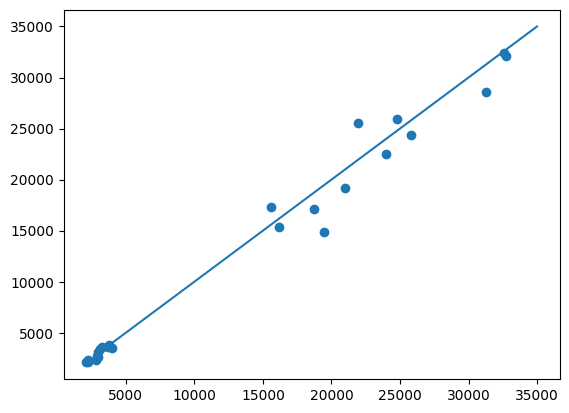

In [11]:
plt.scatter(all_y, sarima_pred)
plt.plot((4000, 35000), (4000, 35000))

In [12]:
baseline_rmse = sqrt(mean_squared_error(all_y, sarima_pred))
baseline_r2 = r2_score(all_y, sarima_pred)
print(f'Baseline SARIMA RMSE: {baseline_rmse:.5f}\nBaseline SARIMA R2: {baseline_r2:.5f}')

Baseline SARIMA RMSE: 1550.43816
Baseline SARIMA R2: 0.98053


# SARIMAX

In [13]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'FSI', 'FXAgainstChina', 'Temperature', 'Precipitation']
target = 'VisitorArrivals'

train_df = aus_df[[target] + candidates]
train_df = train_df.loc[train_df[target].first_valid_index(): train_df[target].last_valid_index()]
train_x, train_y = train_df[candidates], train_df[target]
# train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)
train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
# scaler = StandardScaler()
# train_x = scaler.fit_transform(train_x)
# test_x = scaler.transform(test_x)

In [14]:
train_x

,GDPPerCap,GDP,Population,FSI,FXAgainstChina,Temperature,Precipitation
Date,,,,,,,
2012-01-01,23300.000000,4.054361e+11,17400359.0,43.500000,79.316767,14.3,71.3
2012-02-01,23358.916667,4.068027e+11,17414622.0,43.500000,76.362966,12.7,89.5
2012-03-01,23417.833333,4.081694e+11,17428884.0,43.500000,76.936030,12.3,100.5
2012-04-01,23476.750000,4.095360e+11,17443147.0,43.500000,77.076469,9.4,58.6
2012-05-01,23535.666667,4.109027e+11,17457410.0,43.500000,78.869259,7.6,115.8
...,...,...,...,...,...,...,...
2018-08-01,24993.416667,4.713465e+11,18859173.0,40.691036,96.187380,6.0,78.4
2018-09-01,24988.333333,4.717145e+11,18877745.0,40.691036,99.269181,7.9,98.9
2018-10-01,24983.250000,4.720825e+11,18896318.0,40.691036,98.000754,8.6,69.5


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 522.257232578527
R2 0.2164063096362474


<Axes: xlabel='Date'>

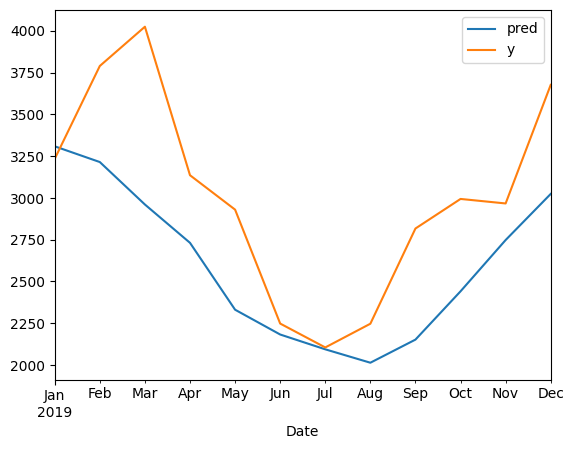

In [15]:
best_param = [(2, 0, 0), (1, 0, 1, 12), 'n']
sarimax_model = sm.tsa.statespace.SARIMAX(train_y, train_x, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
result = sarimax_model.fit(disp=False)
pred = result.forecast(len(test_y), exog=test_x)
print('RMSE:', sqrt(mean_squared_error(test_y, pred)))
print('R2', r2_score(test_y, pred))
pd.concat([pd.Series(pred, name='pred', index=test_y.index), pd.Series(test_y, name='y')], axis=1).plot()

In [16]:
# repeat for chile and maldives
sarimax_pred, all_y = [], []
for f in ['Chile.csv', 'Maldives.csv']:
    print('processing', f)
    df = pd.read_csv(os.path.join(imputed_dir, f))
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[df['Date'] < '2020-01-01']
    df = df.set_index('Date')
    train_df = df[[target] + candidates]
    train_df = train_df.loc[train_df[target].first_valid_index(): train_df[target].last_valid_index()]
    train_x, train_y = train_df[candidates], train_df[target]
    train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
    best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y, train_x, test_x)
    print(best_param, best_rmse, best_r2)
    if best_param is not None:
        sarimax_model = sm.tsa.statespace.SARIMAX(train_y, train_x, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
        result = sarimax_model.fit(disp=False)
        pred = result.forecast(len(test_y), exog=test_x)
    else:
        pred = pd.Series(np.resize(train_y[-12:].values, len(test_y)), name='predictions')
    sarimax_pred.append(pred)
    all_y.append(test_y)
sarimax_pred, all_y = pd.concat(sarimax_pred).values, pd.concat(all_y).values

processing Chile.csv
None 391.268130570329 None
processing Maldives.csv
None 3032.145321385504 None


In [17]:
train_x

,GDPPerCap,GDP,Population,FSI,FXAgainstChina,Temperature,Precipitation
Date,,,,,,,
1998-01-01,12609.000000,3.384931e+09,268445.0,77.822717,1.443896,28.4,209.3
1998-02-01,12653.250000,3.402351e+09,268868.0,77.822717,1.443866,28.9,44.0
1998-03-01,12697.500000,3.419771e+09,269291.0,77.822717,1.449332,29.2,42.2
1998-04-01,12741.750000,3.437191e+09,269714.0,77.822717,1.441005,29.6,95.7
1998-05-01,12786.000000,3.454612e+09,270137.0,77.822717,1.417720,29.2,232.4
...,...,...,...,...,...,...,...
2018-08-01,19211.666667,1.008124e+10,524602.0,72.400000,2.251708,27.8,174.4
2018-09-01,19271.333333,1.013684e+10,525873.0,72.400000,2.250828,28.1,186.3
2018-10-01,19331.000000,1.019244e+10,527144.0,72.400000,2.229661,27.9,227.2


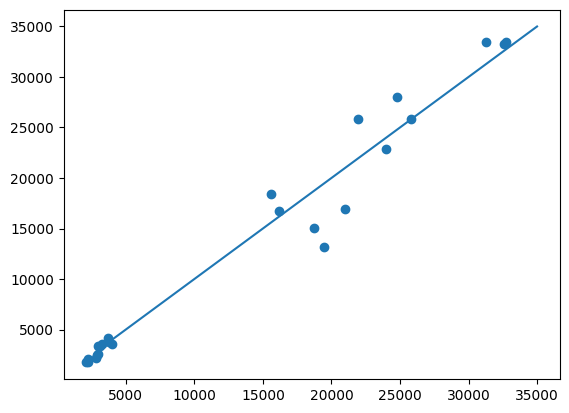

In [18]:
plt.scatter(all_y, sarimax_pred)
plt.plot((4000, 35000), (4000, 35000))

In [19]:
sarimax_rmse = sqrt(mean_squared_error(all_y, sarimax_pred))
sarimax_r2 = r2_score(all_y, sarimax_pred)
print(f'Baseline SARIMAX RMSE: {sarimax_rmse:.5f}\nBaseline SARIMAX R2: {sarimax_r2:.5f}')

Baseline SARIMAX RMSE: 2161.82747
Baseline SARIMAX R2: 0.96215


## Regression

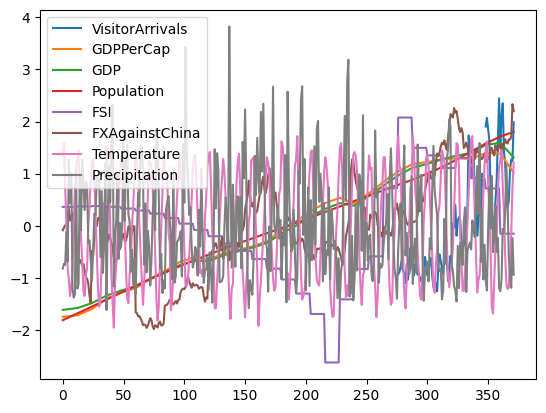

Pearson: 0.42249429643716735
Kendall: 0.414235062742114
Spearman: 0.5604005389976761


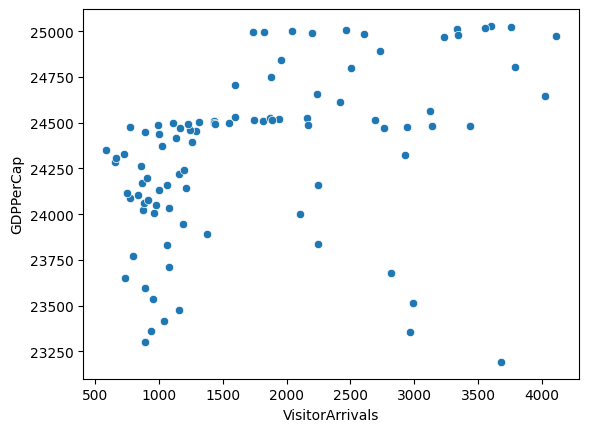

Pearson: 0.7685579932341379
Kendall: 0.5954915100856247
Spearman: 0.8199127975715094


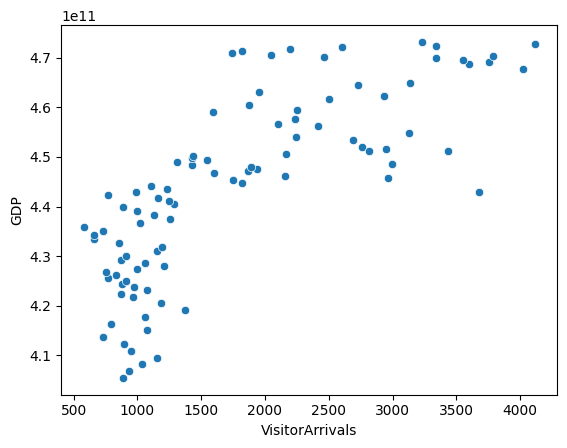

Pearson: 0.8385907387151051
Kendall: 0.6243277630720924
Spearman: 0.8456256073784212


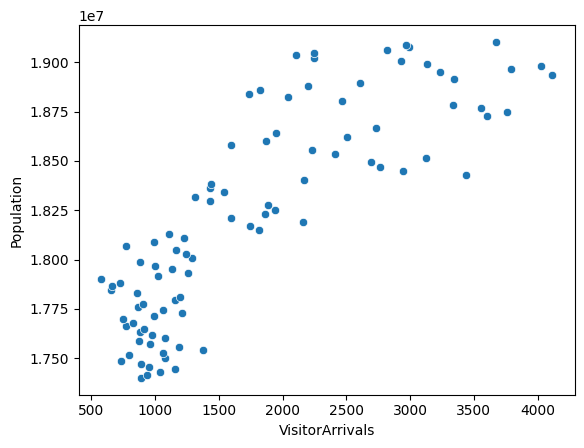

Pearson: -0.726755087654538
Kendall: -0.6070669301646339
Spearman: -0.7969227182295016


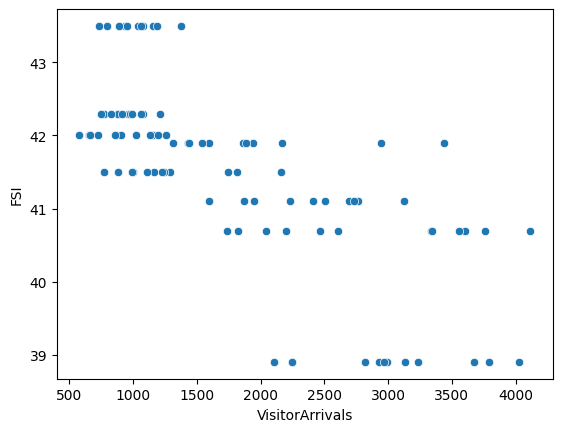

Pearson: 0.46684229403748234
Kendall: 0.28653165665918606
Spearman: 0.4849021230150325


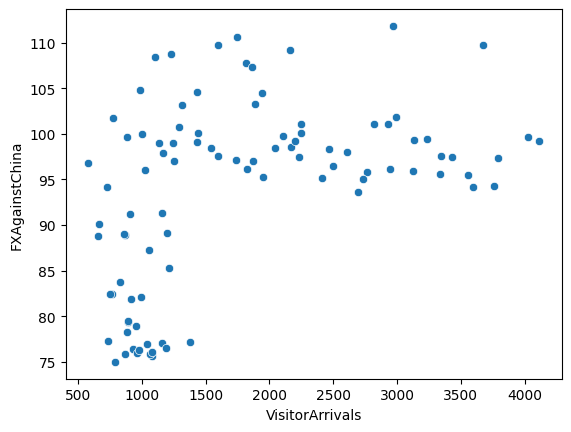

Pearson: 0.2987389570264512
Kendall: 0.17766166405440592
Spearman: 0.26113865235988937


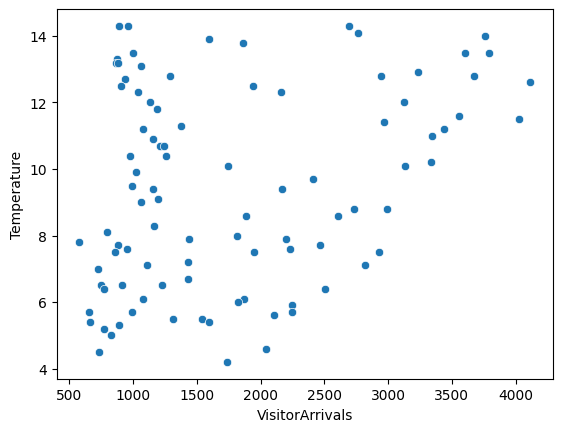

Pearson: -0.19267751089548465
Kendall: -0.10192396855012928
Spearman: -0.16452568457754038


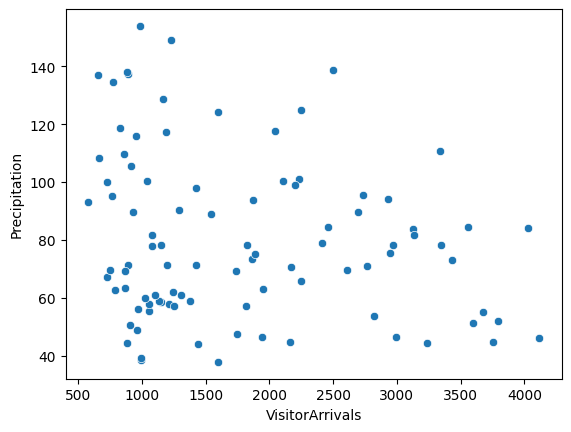

In [20]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'FSI', 'FXAgainstChina', 'Temperature', 'Precipitation']
target = 'VisitorArrivals'
aus_df['Year'] = aus_df.index.year
pd.DataFrame(StandardScaler().fit_transform(aus_df[[target] + candidates]), columns=[target] + candidates).plot()
plt.show()
for candidate in candidates:
    print('Pearson:', aus_df[target].corr(aus_df[candidate]))
    print('Kendall:', aus_df[target].corr(aus_df[candidate], method='kendall'))
    print('Spearman:', aus_df[target].corr(aus_df[candidate], method='spearman'))
    sns.scatterplot(aus_df, x=target, y=candidate)
    plt.show()

In [23]:
train_df = aus_df[[target] + candidates].dropna()
train_x, train_y = train_df[candidates], train_df[target]

train_y, train_x, _ = dummy_lagged_df(train_y, train_x, lag=1)

# train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)
train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]

In [24]:
# sample_weight = get_sample_weight(0.5, 1.0, len(train_x))
best_param, best_rmse = grid_search_ml(train_x, train_y, #sample_weight=sample_weight,
                                         additional_params={'rf': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)],
                                                            'mlp': [{'hidden_layer_sizes': n} for n in (1, 2, 3, 5, 10)],
                                                            'xgb': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)]})
best_param, best_rmse

(('ridge',
  'standard',
  {'alpha_per_target': False,
   'alphas': (0.1, 0.25, 0.5, 1.0, 5.0, 10.0),
   'cv': None,
   'fit_intercept': True,
   'gcv_mode': None,
   'scoring': None,
   'store_cv_values': False}),
 329.67672208974557)

RMSE: 469.88518
R2: 0.36568


<Axes: xlabel='Date'>

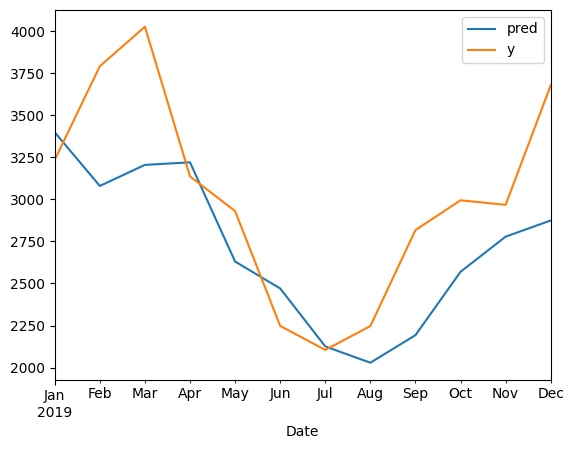

In [25]:
model = get_model(best_param[0])
model = model.set_params(**best_param[2])
scaler = get_scaler(best_param[1])
train_x_ = scaler.fit_transform(train_x)
test_x_ = scaler.transform(test_x)
model.fit(train_x_, train_y, )#sample_weight=sample_weight)
pred = model.predict(test_x_)
linear_r2 = r2_score(test_y, pred)
linear_rmse = sqrt(mean_squared_error(test_y, pred))
print(f'RMSE: {linear_rmse:.5f}\nR2: {linear_r2:.5f}')

pd.concat([pd.Series(pred, name='pred', index=test_y.index), pd.Series(test_y, name='y')], axis=1).plot()

In [26]:
# repeat for all countries
reg_pred, all_y = [], []
for f in ['Chile.csv', 'Maldives.csv']:
    if f.endswith('.csv'):
        print('processing', f)
        df = pd.read_csv(os.path.join(imputed_dir, f))
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[df['Date'] < '2020-01-01']
        df = df.set_index('Date')

        train_df = df[[target] + candidates].dropna()
        train_x, train_y = train_df[candidates], train_df[target]
        
        train_y, train_x, _ = dummy_lagged_df(train_y, train_x, lag=1)
        
        train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
        # sample_weight = get_sample_weight(0.5, 1.0, len(train_x))

        best_param, best_rmse = grid_search_ml(train_x, train_y, #sample_weight=sample_weight,
                                                 additional_params={'rf': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)],
                                                                    'mlp': [{'hidden_layer_sizes': n} for n in (1, 2, 3, 5, 10)],
                                                                    'xgb': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)]})
        print(best_param, best_rmse)
        model = get_model(best_param[0])
        model = model.set_params(**best_param[2])
        scaler = get_scaler(best_param[1])
        train_x_ = scaler.fit_transform(train_x)
        test_x_ = scaler.transform(test_x)
        model.fit(train_x_, train_y,)# sample_weight=sample_weight)
        pred = model.predict(test_x_)
        reg_pred.append(pred)
        all_y.append(test_y)
reg_pred, all_y = np.concatenate(reg_pred), pd.concat(all_y).values

processing Chile.csv
('ridge', 'standard', {'alpha_per_target': False, 'alphas': (0.1, 0.25, 0.5, 1.0, 5.0, 10.0), 'cv': None, 'fit_intercept': True, 'gcv_mode': None, 'scoring': None, 'store_cv_values': False}) 329.67672208974557
processing Maldives.csv
('rf', 'standard', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 3, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}) 3354.1982365175113


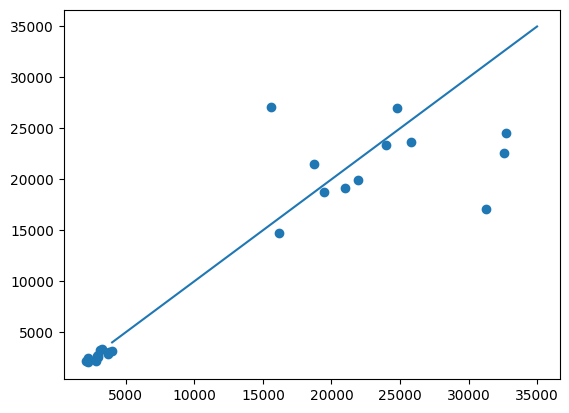

In [27]:
plt.scatter(all_y, reg_pred)
plt.plot((4000, 35000), (4000, 35000))

In [28]:
reg_rmse = sqrt(mean_squared_error(all_y, reg_pred))
reg_r2 = r2_score(all_y, reg_pred)
print(f'Baseline Model RMSE: {reg_rmse:.5f}\nBaseline Model R2: {reg_r2:.5f}')

Baseline Model RMSE: 4697.19354
Baseline Model R2: 0.82132


# RNN

In [29]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'FSI', 'FXAgainstChina', 'Country', 'Temperature', 'Precipitation']
target = 'VisitorArrivals'
seq_len = 7

seq_train_x, seq_train_y, seq_test_x, seq_test_y, x_scaler, y_scaler, train_country = load_data(imputed_dir, candidates, target, seq_len, reverse=False, freq='MS', remove_covid=True, test_size=1*12,
                                                                                                preprocess='minmax', single_x_scaler=False, single_y_scaler=True)
# seq_test_x = pd.concat(seq_test_x, ignore_index=True)

In [30]:
seq_test_x[-1]

,GDPPerCap,GDP,Population,FSI,FXAgainstChina,Country,Temperature,Precipitation,ShiftedTarget
192,0.835330,0.902742,1.029472,-0.296296,0.675663,Austria,0.585938,0.956565,0.017708
193,0.792628,0.876731,1.035094,-0.296296,0.641738,Austria,0.933594,0.368947,0.019813
194,0.749925,0.850719,1.040716,-0.296296,0.663760,Austria,0.945312,0.637044,0.023154
195,0.707223,0.824707,1.046338,-0.296296,0.624211,Austria,0.937500,0.564653,0.022108
196,0.664521,0.798695,1.051960,-0.296296,0.631097,Austria,0.746094,0.576635,0.018301
197,0.621819,0.772683,1.057582,-0.296296,0.627679,Austria,0.609375,0.377434,0.020953
198,0.579117,0.746672,1.063203,-0.296296,0.651940,Austria,0.394531,0.548677,0.012360


In [31]:
seq_train_x, seq_val_x, seq_train_y, seq_val_y = train_test_split(seq_train_x, seq_train_y, test_size=0.2, stratify=train_country)
train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
# train_dataset.initialize_states()
val_dataset = TimeSeriesDataset(seq_val_x, seq_val_y,)# (model.num_layers, model.hidden_size))
# val_dataset.set_initial_states(train_dataset.get_initial_states())
test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y,)# (model.num_layers, model.hidden_size))
# test_dataset.set_initial_states(train_dataset.get_initial_states())

In [32]:
model = ForecastModel('gru', input_size=8, num_layers=2, conditional_labels=np.unique(train_country).tolist())
optimizer = get_torch_optimizer('sgd', model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [33]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, pin_memory=True)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=1, pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

In [34]:
test_dataset.__getitem__(-1)

('Austria',
 array([[ 0.83532972,  0.90274232,  1.02947161, -0.2962963 ,  0.67566293,
          0.5859375 ,  0.95656515,  0.01770801],
        [ 0.79262756,  0.87673053,  1.03509446, -0.2962963 ,  0.64173752,
          0.93359375,  0.36894658,  0.01981324],
        [ 0.7499254 ,  0.85071874,  1.04071599, -0.2962963 ,  0.66375958,
          0.9453125 ,  0.63704443,  0.02315448],
        [ 0.70722324,  0.82470695,  1.04633752, -0.2962963 ,  0.62421079,
          0.9375    ,  0.56465302,  0.02210773],
        [ 0.66452108,  0.79869516,  1.05196037, -0.2962963 ,  0.63109689,
          0.74609375,  0.57663505,  0.01830085],
        [ 0.62181892,  0.77268337,  1.0575819 , -0.2962963 ,  0.6276791 ,
          0.609375  ,  0.37743385,  0.02095273],
        [ 0.57911676,  0.74667158,  1.06320343, -0.2962963 ,  0.6519404 ,
          0.39453125,  0.54867698,  0.01235951]]),
 0.010156418252226018)

In [35]:
test_dataset.x_dfs[-1]

,GDPPerCap,GDP,Population,FSI,FXAgainstChina,Country,Temperature,Precipitation,ShiftedTarget
192,0.835330,0.902742,1.029472,-0.296296,0.675663,Austria,0.585938,0.956565,0.017708
193,0.792628,0.876731,1.035094,-0.296296,0.641738,Austria,0.933594,0.368947,0.019813
194,0.749925,0.850719,1.040716,-0.296296,0.663760,Austria,0.945312,0.637044,0.023154
195,0.707223,0.824707,1.046338,-0.296296,0.624211,Austria,0.937500,0.564653,0.022108
196,0.664521,0.798695,1.051960,-0.296296,0.631097,Austria,0.746094,0.576635,0.018301
197,0.621819,0.772683,1.057582,-0.296296,0.627679,Austria,0.609375,0.377434,0.020953
198,0.579117,0.746672,1.063203,-0.296296,0.651940,Austria,0.394531,0.548677,0.012360


Epoch 0: train loss 0.0178, val loss 0.0162, time 3.6901
Epoch 1: train loss 0.0153, val loss 0.0154, time 3.2069
Epoch 2: train loss 0.0140, val loss 0.0148, time 3.1933
Epoch 3: train loss 0.0135, val loss 0.0143, time 3.1459
Epoch 4: train loss 0.0132, val loss 0.0138, time 3.1920
Epoch 5: train loss 0.0127, val loss 0.0134, time 3.1982
Epoch 6: train loss 0.0124, val loss 0.0130, time 3.1466
Epoch 7: train loss 0.0119, val loss 0.0125, time 3.1722
Epoch 8: train loss 0.0115, val loss 0.0121, time 3.1825
Epoch 9: train loss 0.0109, val loss 0.0117, time 3.2100
Epoch 10: train loss 0.0106, val loss 0.0111, time 3.0926
Epoch 11: train loss 0.0106, val loss 0.0106, time 3.1412
Epoch 12: train loss 0.0098, val loss 0.0101, time 3.1745
Epoch 13: train loss 0.0089, val loss 0.0095, time 3.2082
Epoch 14: train loss 0.0087, val loss 0.0089, time 3.1397
Epoch 15: train loss 0.0084, val loss 0.0083, time 3.2308
Epoch 16: train loss 0.0079, val loss 0.0078, time 3.1727
Epoch 17: train loss 0.0

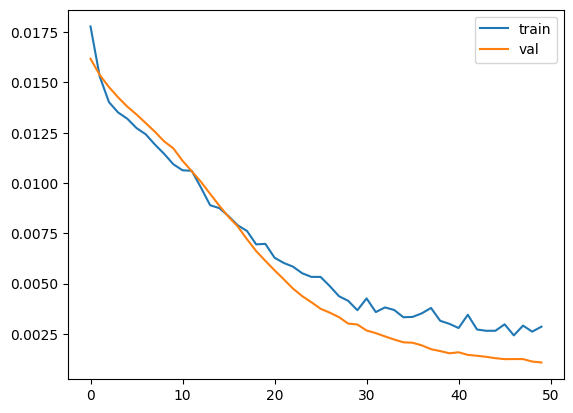

In [36]:
model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, val_dataloader, cuda=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [37]:
len(train_dataset) + len(val_dataset)

4093

In [ ]:
best_param, best_rmse = grid_search_rnn(imputed_dir, candidates, target, input_size=8, param_grids={'seq_len': [10, 25, 50], 'hidden_size': [10, 20, 50], 'num_layers': range(1, 3)},
                                        freq='MS', remove_covid=True, test_size=1*12, max_epochs=10)
best_param, best_rmse

Epoch 0: train loss 0.3215, val loss 0.2340, time 3.2065
Epoch 1: train loss 0.0629, val loss 0.1796, time 2.9951
Epoch 2: train loss 0.0533, val loss 0.1544, time 2.9872
Epoch 3: train loss 0.0443, val loss 0.1508, time 3.0512
Epoch 4: train loss 0.0446, val loss 0.1544, time 3.0390
Epoch 5: train loss 0.0492, val loss 0.1441, time 3.0283
Epoch 6: train loss 0.0438, val loss 0.1601, time 3.0513
Epoch 7: train loss 0.0518, val loss 0.1246, time 3.0717
Epoch 8: train loss 0.0457, val loss 0.1269, time 2.9895
Epoch 9: train loss 0.0521, val loss 0.1565, time 3.0141
warning not converged


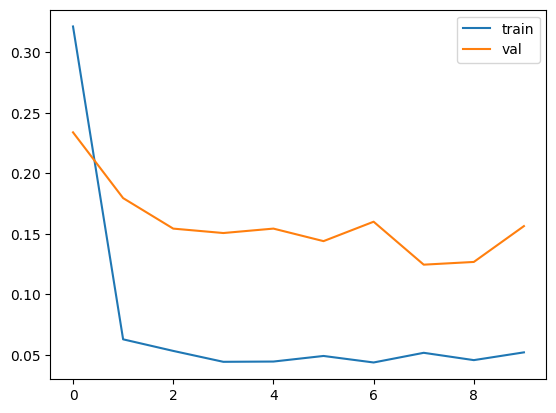

In [38]:
best_param = ({'preprocess': 'standard', 'seq_len': 20, 'batch_size': 64}, 
              {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 20}, 
              {'optim_type': 'rmsprop', 'lr': 0.0001})

seq_train_x, seq_train_y, seq_test_x, seq_test_y, x_scaler, y_scaler, train_country = load_data(imputed_dir, candidates, target, best_param[0]['seq_len'], freq='MS', remove_covid=True, test_size=1*12,
                                                                                                reverse=False, preprocess=best_param[0]['preprocess'], single_y_scaler=True)
model = ForecastModel(**best_param[1], input_size=8, conditional_labels=np.unique(train_country).tolist())
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = nn.MSELoss()

train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
# train_dataset.initialize_states()
test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y,)# (model.num_layers, model.hidden_size))
# test_dataset.set_initial_states(train_dataset.get_initial_states())
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=10)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [39]:
rnn_preds, _ = eval_rnn(model, criterion, test_dataloader)
rnn_preds = y_scaler.inverse_transform(np.expand_dims(rnn_preds, -1)).flatten()

In [40]:
idx = []
for i in range(len(test_dataset)):
    cond_label, _, _ = test_dataset.__getitem__(i)
    if cond_label in ['Chile', 'Maldives']:
        idx.append(i)
assert len(idx) == len(all_y)
rnn_preds = rnn_preds[idx]

In [41]:
dataloader_gt = []
for _, _, y_batch in test_dataloader:
    dataloader_gt.append(y_batch.item())
dataloader_gt = y_scaler.inverse_transform(np.expand_dims(np.asarray(dataloader_gt), -1)).flatten()

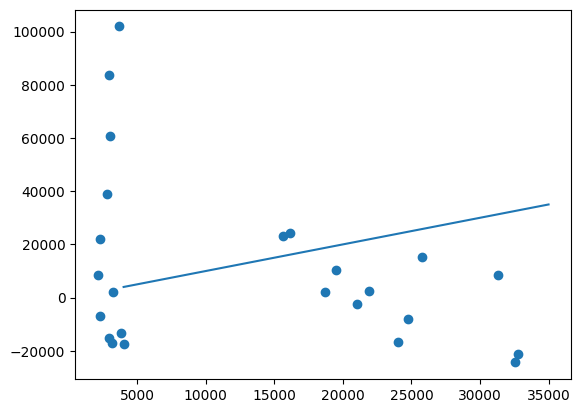

In [42]:
plt.scatter(all_y, rnn_preds)
plt.plot((4000, 35000), (4000, 35000))

In [43]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_preds))
rnn_r2 = r2_score(all_y, rnn_preds)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}')

RNN RMSE: 37483.09272
RNN R2: -10.37838


# Separate RNN models

In [44]:
rnn_sep_pred = []
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        country = f.split('.')[0]
        if country not in ['Chile', 'Maldives']:
            continue
        print('processing', f)
        best_param, best_rmse = grid_search_rnn(imputed_dir, candidates, target, emb_dict=None, freq='MS', test_size=1*12, input_size=8, max_epochs=10,
                                                param_grids={'seq_len': [10, 20, 50], 'hidden_size': [10, 20, 30], 'num_layers': range(1, 2), 
                                                             'batch_size': [64, 128], 'lr': [0.0001, 0.00005, 0.00001]},
                                                country_filter=country, verbose=False)
        print(best_param, best_rmse)

        seq_train_x, seq_train_y, seq_test_x, seq_test_y, x_scaler, y_scaler, train_country = load_data(imputed_dir, candidates, target, best_param[0]['seq_len'], freq='MS', test_size=1*12, reverse=False, country_filter=country, preprocess=best_param[0]['preprocess'], single_y_scaler=True)
        model = ForecastModel(**best_param[1], input_size=8, conditional_labels=np.unique(train_country).tolist())
        optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
        criterion = nn.MSELoss()

        train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
        # train_dataset.initialize_states()
        test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y,)# (model.num_layers, model.hidden_size))
        # test_dataset.set_initial_states(train_dataset.get_initial_states())
        train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, pin_memory=True)
        test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

        model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, epochs=10, cuda=True, verbose=False)
        preds, _ = eval_rnn(model, criterion, test_dataloader)
        preds = y_scaler.inverse_transform(np.expand_dims(preds, -1)).flatten()
        rnn_sep_pred.append(preds)
rnn_sep_pred = np.concatenate(rnn_sep_pred)

processing Chile.csv
({'preprocess': 'standard', 'seq_len': 50, 'batch_size': 128}, {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 20}, {'optim_type': 'rmsprop', 'lr': 0.001}) 0.23419355174718853
processing Maldives.csv
({'preprocess': 'standard', 'seq_len': 10, 'batch_size': 64}, {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 30}, {'optim_type': 'rmsprop', 'lr': 0.0005}) 0.24934593140246736


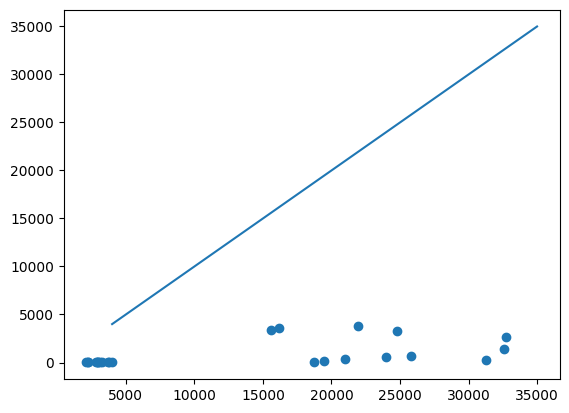

In [45]:
plt.scatter(all_y, rnn_sep_pred)
plt.plot((4000, 35000), (4000, 35000))

In [46]:
rnn_sep_rmse = sqrt(mean_squared_error(all_y, rnn_sep_pred))
rnn_sep_r2 = r2_score(all_y, rnn_sep_pred)
print(f'Separate RNN RMSE: {rnn_sep_rmse:.5f}\n Separate RNN R2: {rnn_sep_r2:.5f}')

Separate RNN RMSE: 16295.83355
 Separate RNN R2: -1.15062


# Full Run
Best model seems to be SARIMA

processing Chile.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


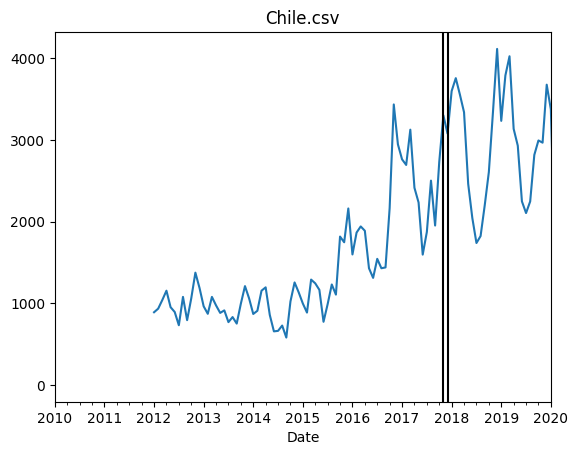

/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Maldives.csv


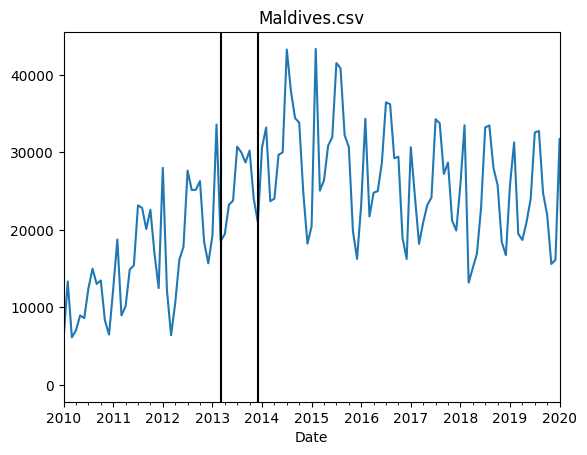

In [47]:
# fill missing values with sarima

for f in ['Chile.csv', 'Maldives.csv']:
    print('processing', f)
    full_df = pd.read_csv(os.path.join(imputed_dir, f))
    full_df['Date'] = pd.to_datetime(full_df['Date'])
    full_df = full_df.set_index('Date')
    df = full_df.copy()
    df = df[df.index < '2020-01-01']

    # forward
    train_full = df[target]
    train_y = train_full.loc[train_full.first_valid_index(): train_full.last_valid_index()]
    train_y, test_y = train_y.iloc[:-1*12], train_y.iloc[-1*12:]
    
    if f == 'Chile.csv':
        best_param = [(2, 0, 1), (1, 0, 1, 12), 'n']
    elif f == 'Maldives.csv':
        best_param = [(2, 0, 1), (1, 1, 1, 12), 'n']
    else:
        best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y)
        print(best_param, best_rmse, best_r2)
    train_y = train_full.loc[train_full.first_valid_index(): train_full.last_valid_index()]
    test_y = train_y[train_y.isna()]
    sarima_model = sm.tsa.statespace.SARIMAX(train_y, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
    result = sarima_model.fit(disp=False)
    pred = result.predict(test_y.index.min(), test_y.index.max())
    pred_df = pd.DataFrame({'VisitorImputed': pred}, index=test_y.index).astype(int)

    full_df[target] = full_df[target].fillna(full_df.merge(pred_df, how='left', left_index=True, right_index=True)['VisitorImputed'])
    full_df.reset_index(names='Date')
    full_df[target].plot()
    plt.title(f)
    plt.axvline(test_y.index.min(), color='black')
    plt.axvline(test_y.index.max(), color='black')
    plt.xlim(datetime(2010, 1, 1), datetime(2020, 1, 1))
    plt.show()
    full_df.to_csv(os.path.join(imputed_dir, f))
    # break